# Session 10: Stock-Bond Correlations and Equity Valuations

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from dotenv import load_dotenv
import yfinance as yf
from datetime import datetime, timedelta

# Load environment variables
load_dotenv()
fred_api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=fred_api_key)

print(f"FRED API key loaded: {fred_api_key[:10]}...")

FRED API key loaded: 1383c60c37...


## FRED Series IDs

### Equity Market Data
- **SP500**: S&P 500 Index
- **MULTPL/SP500_PE_RATIO_MONTH**: S&P 500 P/E Ratio (if available)
- **MULTPL/SHILLER_PE_RATIO_MONTH**: Shiller CAPE Ratio (if available)

### Bond Yields
- **DGS10**: 10-Year Treasury Constant Maturity Rate
- **DGS3**: 3-Year Treasury
- **DGS5**: 5-Year Treasury

### Alternative Sources
We'll use Yahoo Finance for S&P 500 returns and may need to calculate correlations manually

In [36]:
# Fetch S&P 500 data from Yahoo Finance
print("Fetching S&P 500 data from Yahoo Finance...")
sp500 = yf.download('^GSPC', start='1900-01-01', progress=False)
sp500_monthly = sp500['Close'].resample('M').last()
sp500_returns = sp500_monthly.pct_change()

sp500_returns = sp500_returns['^GSPC']

print(f"S&P 500 data: {len(sp500_monthly)} monthly observations")
print(f"Date range: {sp500_monthly.index.min()} to {sp500_monthly.index.max()}")

Fetching S&P 500 data from Yahoo Finance...
S&P 500 data: 1178 monthly observations
Date range: 1927-12-31 00:00:00 to 2026-01-31 00:00:00


/var/folders/6p/l4s0yjhj757dpt1v1vj382tw0000gq/T/ipykernel_49280/2375056127.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly = sp500['Close'].resample('M').last()


In [35]:
# Fetch Treasury yields from FRED
treasury_series = {
    '3Y': 'DGS3',
    '5Y': 'DGS5',
    '10Y': 'DGS10',
}

treasury_data = {}
for name, series_id in treasury_series.items():
    try:
        series = fred.get_series(series_id, observation_start='1900-01-01')
        # Resample to monthly
        treasury_data[name] = series.resample('M').last()
        print(f"Fetched {name}: {len(treasury_data[name])} observations")
    except Exception as e:
        print(f"Error fetching {name} ({series_id}): {e}")

df_yields = pd.DataFrame(treasury_data)
print(f"\nYields DataFrame shape: {df_yields.shape}")

/var/folders/6p/l4s0yjhj757dpt1v1vj382tw0000gq/T/ipykernel_49280/1324167064.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  treasury_data[name] = series.resample('M').last()


Fetched 3Y: 769 observations
Fetched 5Y: 769 observations
Fetched 10Y: 769 observations

Yields DataFrame shape: (769, 3)


In [34]:
# Calculate bond returns (approximation using yield changes)
# For simplicity, we'll use Treasury ETF data for more accurate returns
print("\nFetching Treasury ETF data for bond returns...")

# TLT is the iShares 20+ Year Treasury Bond ETF (proxy for long-term bonds)
# IEF is the iShares 7-10 Year Treasury Bond ETF (proxy for intermediate bonds)
tlt = yf.download('TLT', start='1900-07-01', progress=False)  # TLT inception
ief = yf.download('IEF', start='1900-07-01', progress=False)  # IEF inception

tlt_monthly = tlt['Close'].resample('M').last()
ief_monthly = ief['Close'].resample('M').last()

tlt_returns = tlt_monthly.pct_change()
ief_returns = ief_monthly.pct_change()

print(f"TLT (20Y+ Treasury ETF) data: {len(tlt_monthly)} observations")
print(f"IEF (7-10Y Treasury ETF) data: {len(ief_monthly)} observations")

tlt_returns = tlt_returns['TLT']
ief_returns = ief_returns['IEF']



Fetching Treasury ETF data for bond returns...
TLT (20Y+ Treasury ETF) data: 283 observations
IEF (7-10Y Treasury ETF) data: 283 observations


/var/folders/6p/l4s0yjhj757dpt1v1vj382tw0000gq/T/ipykernel_49280/739302029.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tlt_monthly = tlt['Close'].resample('M').last()
/var/folders/6p/l4s0yjhj757dpt1v1vj382tw0000gq/T/ipykernel_49280/739302029.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ief_monthly = ief['Close'].resample('M').last()


## Figure 1: Stock-Bond Rolling Correlations (3Y and 5Y)

In [38]:
# Calculate rolling correlations between S&P 500 and bond returns
# Align data
returns_df = pd.DataFrame({
    'SP500': sp500_returns,
    'Bonds_Long': tlt_returns,
    'Bonds_Mid': ief_returns
}).dropna()

# Calculate rolling correlations
# 3-year rolling window = 36 months
# 5-year rolling window = 60 months
window_3y = 36
window_5y = 60

corr_3y = returns_df['SP500'].rolling(window=window_3y).corr(returns_df['Bonds_Long'])
corr_5y = returns_df['SP500'].rolling(window=window_5y).corr(returns_df['Bonds_Long'])

print(f"Correlation data calculated")
print(f"3Y correlation range: {corr_3y.min():.3f} to {corr_3y.max():.3f}")
print(f"5Y correlation range: {corr_5y.min():.3f} to {corr_5y.max():.3f}")

Correlation data calculated
3Y correlation range: -0.788 to 0.678
5Y correlation range: -0.668 to 0.568


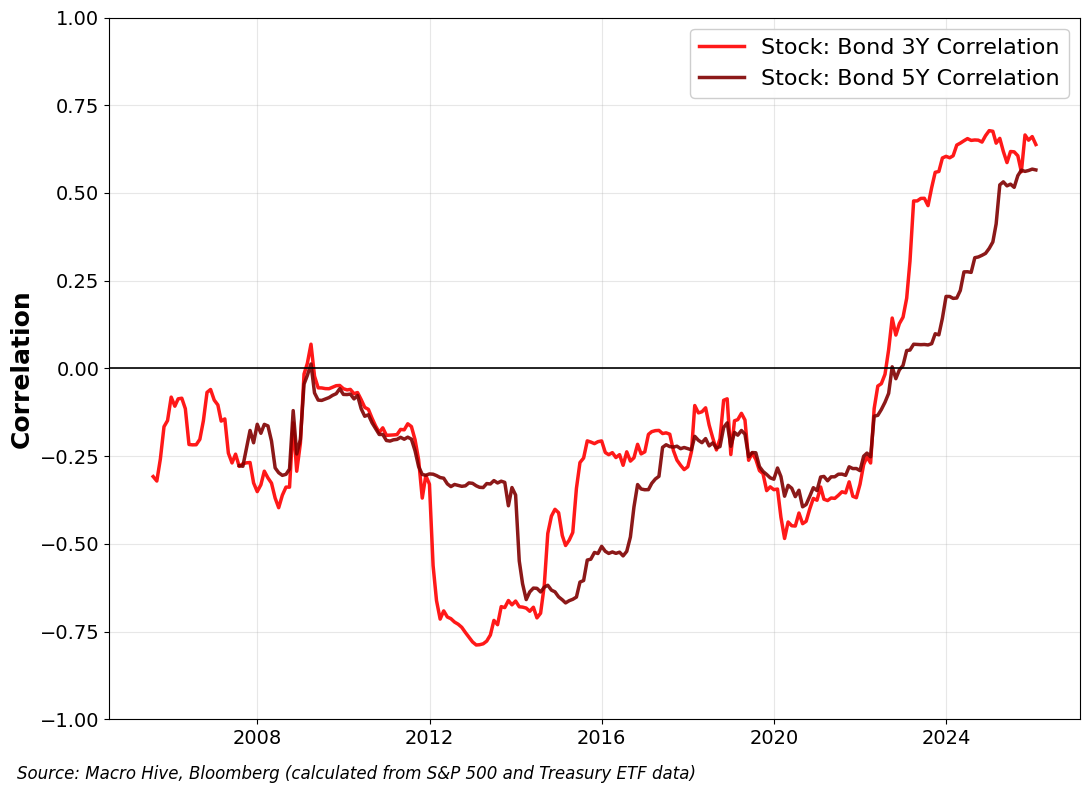

Figure saved to ../figures/stock_bond_correlation.png


In [39]:
# Create figure for stock-bond correlations
fig, ax = plt.subplots(figsize=(11, 8))

# Plot correlations
ax.plot(corr_3y.index, corr_3y, 
        color='red', linewidth=2.5, label='Stock: Bond 3Y Correlation', alpha=0.9)
ax.plot(corr_5y.index, corr_5y, 
        color='maroon', linewidth=2.5, label='Stock: Bond 5Y Correlation', alpha=0.9)

# Add zero line
ax.axhline(y=0, color='black', linewidth=1.2, linestyle='-')

# Customize
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Correlation', fontsize=18, fontweight='bold')
ax.set_ylim(-1.0, 1.0)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)
ax.legend(loc='upper right', fontsize=16, framealpha=0.95)
ax.tick_params(axis='both', which='major', labelsize=14)

# Add source
fig.text(0.02, 0.02, 'Source: Macro Hive, Bloomberg (calculated from S&P 500 and Treasury ETF data)', 
         fontsize=12, style='italic')

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig('../figures/stock_bond_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/stock_bond_correlation.png")

## Load Historical P/E and CAPE Data

We'll try to get Shiller CAPE data from FRED or calculate it from available data

In [48]:
df_shiller.columns

Index(['Date', 'P', 'D', 'E', 'CPI', 'Fraction', 'Rate GS10', 'Price',
       'Dividend', 'Price.1', 'Earnings', 'Earnings.1', 'CAPE', 'Unnamed: 13',
       'TR CAPE', 'Unnamed: 15', 'Yield', 'Returns', 'Returns.1',
       'Real Return', 'Real Return.1', 'Returns.2'],
      dtype='object')

In [53]:
# Try to fetch Shiller PE (CAPE) from various sources
# FRED may have this data, or we can download from Robert Shiller's website

try:
    # Try FRED first - note: series name may vary
    cape = fred.get_series('CAPE', observation_start='1870-01-01')
    print(f"Fetched CAPE from FRED: {len(cape)} observations")
except:
    print("CAPE not available directly from FRED")
    print("Attempting to fetch from alternative source...")
    
    # Alternative: Download Shiller's data directly
    try:
        # Robert Shiller's data URL
        shiller_url = 'http://www.econ.yale.edu/~shiller/data/ie_data.xls'
        
        # Read the Excel file (skip header rows)
        df_shiller = pd.read_excel(shiller_url, sheet_name='Data', skiprows=7)[['Date', 'P', 'D', 'E', 'CAPE']].rename(columns={'P': 'SP500', 'D': 'Dividend', 'E': 'Earnings'})
        df_shiller = df_shiller.dropna()

        # Convert date (format is YYYY.MM as decimal)
        df_shiller['Year'] = df_shiller['Date'].astype(str).str.split('.').str[0].astype(int)
        df_shiller['Month'] = ((df_shiller['Date'] % 1) * 12).round().astype(int)
        df_shiller['Month'] = df_shiller['Month'].replace(0, 1)  # Replace 0 with 1
        
        df_shiller['DateTime'] = pd.to_datetime(
            df_shiller['Year'].astype(str) + '-' + 
            df_shiller['Month'].astype(str) + '-01'
        )
        
        df_shiller = df_shiller.set_index('DateTime')
        df_shiller = df_shiller[df_shiller.index >= '1871-01-01']
        
        # Extract CAPE and PE ratios
        cape = df_shiller['CAPE'].dropna()
        
        # Calculate regular P/E ratio
        df_shiller['PE'] = df_shiller['SP500'] / df_shiller['Earnings']
        pe_ratio = df_shiller['PE'].dropna()

        df_shiller['P/D'] = df_shiller['SP500'] / df_shiller['Dividend']
        pd_ratio = df_shiller['P/D'].dropna()
        
        print(f"Successfully loaded Shiller data")
        print(f"CAPE: {len(cape)} observations from {cape.index.min()} to {cape.index.max()}")
        print(f"P/E: {len(pe_ratio)} observations")
        
    except Exception as e:
        print(f"Error loading Shiller data: {e}")
        print("Will create synthetic data for demonstration")
        cape = None
        pe_ratio = None

CAPE not available directly from FRED
Attempting to fetch from alternative source...
Successfully loaded Shiller data
CAPE: 1710 observations from 1881-01-01 00:00:00 to 2023-01-01 00:00:00
P/E: 1710 observations


## Figure 2: S&P 500 P/D Ratio and Shiller CAPE

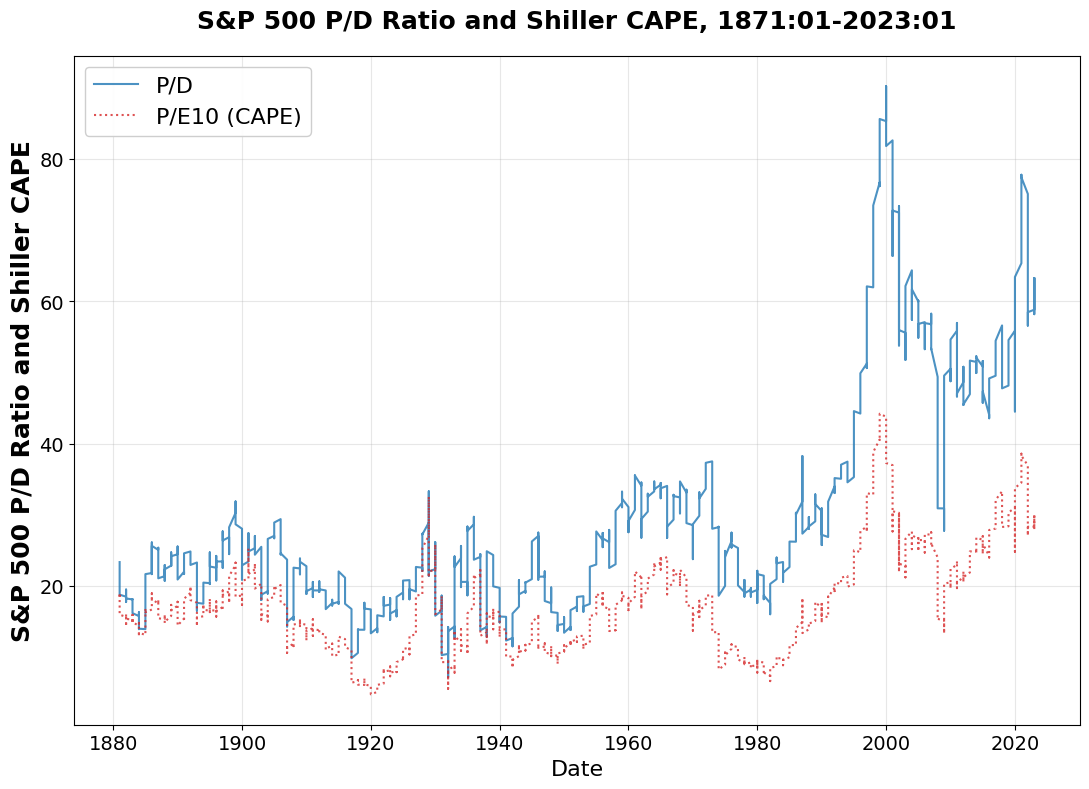

Figure saved to ../figures/sp500_pe_cape.png


In [63]:
# Create figure for P/E and CAPE
if cape is not None and pe_ratio is not None:
    fig, ax = plt.subplots(figsize=(11, 8))
    
    # Filter data from 1871 to present
    plot_start = '1871-01-01'
    plot_end = '2025-07-01'
    
    pd_plot = pd_ratio.loc[plot_start:plot_end]
    cape_plot = cape.loc[plot_start:plot_end]
    
    # Plot both ratios
    ax.plot(pd_plot.index, pd_plot, 
            color='#1f77b4', linewidth=1.5, label='P/D', alpha=0.8)
    ax.plot(cape_plot.index, cape_plot, 
            color='#d62728', linewidth=1.5, label='P/E10 (CAPE)', 
            linestyle=':', alpha=0.8)
    
    # Customize
    ax.set_xlabel('Date', fontsize=16)
    ax.set_ylabel('S&P 500 P/D Ratio and Shiller CAPE', fontsize=18, fontweight='bold')
    ax.set_title('S&P 500 P/D Ratio and Shiller CAPE, 1871:01-2023:01', 
                 fontsize=18, fontweight='bold', pad=20)
    # ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
    ax.set_axisbelow(True)
    ax.legend(loc='upper left', fontsize=16, framealpha=0.95)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    plt.savefig('../figures/sp500_pe_cape.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Figure saved to ../figures/sp500_pe_cape.png")
else:
    print("CAPE data not available - skipping P/E and CAPE chart")

## Figure 3: Long-term Bond Yields and Shiller CAPE

In [57]:
# Fetch long-term bond yield data from FRED
# Try to get as much historical data as possible
try:
    # Long-term government bond yield (10-year)
    long_rate = fred.get_series('GS10', observation_start='1871-01-01')
    print(f"Fetched 10-Year Treasury: {len(long_rate)} observations")
except:
    print("Using DGS10 for 10-year yield")
    long_rate = df_yields['10Y']

# Resample to monthly if needed
if long_rate is not None:
    long_rate_monthly = long_rate.resample('M').last()
    print(f"Long-term rate range: {long_rate_monthly.index.min()} to {long_rate_monthly.index.max()}")

Fetched 10-Year Treasury: 873 observations
Long-term rate range: 1953-04-30 00:00:00 to 2025-12-31 00:00:00


/var/folders/6p/l4s0yjhj757dpt1v1vj382tw0000gq/T/ipykernel_49280/273638793.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  long_rate_monthly = long_rate.resample('M').last()


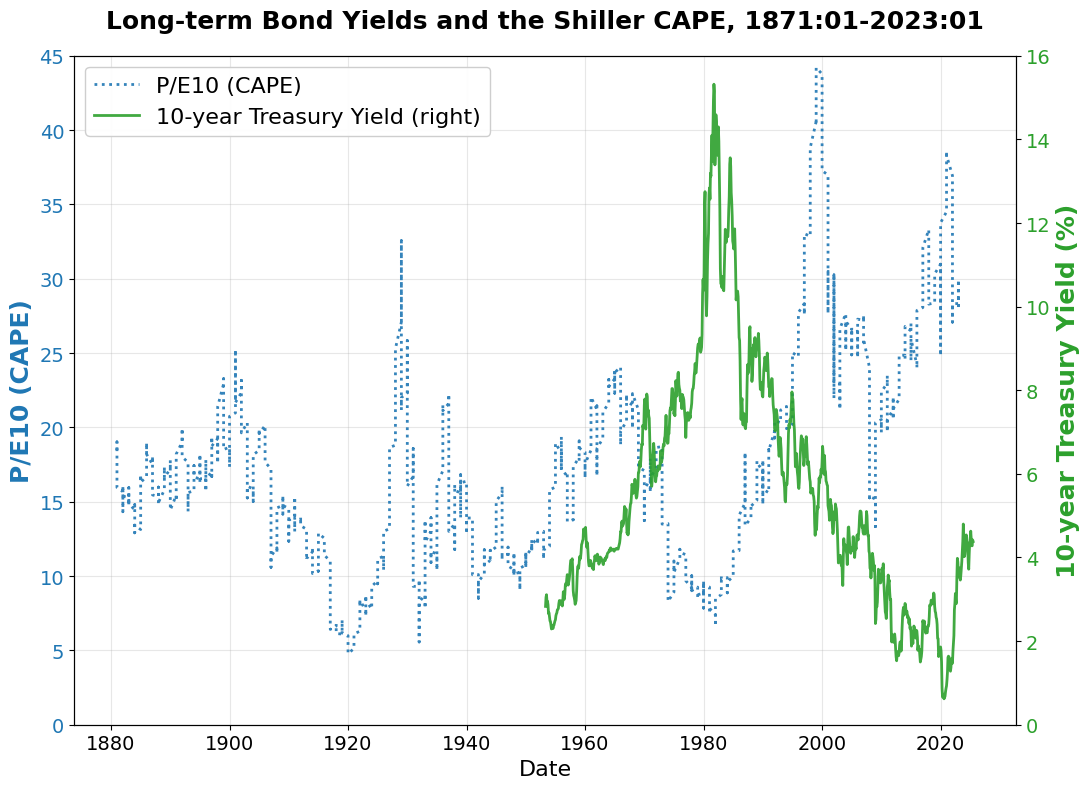

Figure saved to ../figures/bond_yields_cape.png


In [67]:
# Create dual-axis figure
if cape is not None and long_rate is not None:
    fig, ax1 = plt.subplots(figsize=(11, 8))
    
    # Filter to common date range
    plot_start = '1871-01-01'
    plot_end = '2025-07-01'
    
    cape_plot = cape.loc[plot_start:plot_end]
    
    # Primary axis: CAPE
    color1 = '#1f77b4'
    ax1.set_xlabel('Date', fontsize=16)
    ax1.set_ylabel('P/E10 (CAPE)', fontsize=18, fontweight='bold', color=color1)
    line1 = ax1.plot(cape_plot.index, cape_plot, 
                     color=color1, linewidth=2, label='P/E10 (CAPE)', 
                     linestyle=':', alpha=0.9)
    ax1.tick_params(axis='y', labelcolor=color1, labelsize=14)
    ax1.set_ylim(0, 45)
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
    ax1.set_axisbelow(True)
    
    # Secondary axis: Long-term bond yield
    ax2 = ax1.twinx()
    color2 = '#2ca02c'
    ax2.set_ylabel('10-year Treasury Yield (%)', fontsize=18, fontweight='bold', color=color2)
    
    # Align the bond yield data with CAPE date range
    rate_plot = long_rate_monthly.loc[plot_start:plot_end]
    
    line2 = ax2.plot(rate_plot.index, rate_plot, 
                     color=color2, linewidth=2, label='10-year Treasury Yield (right)', alpha=0.9)
    ax2.tick_params(axis='y', labelcolor=color2, labelsize=14)
    ax2.set_ylim(0, 16)
    
    # Title
    ax1.set_title('Long-term Bond Yields and the Shiller CAPE, 1871:01-2023:01', 
                  fontsize=18, fontweight='bold', pad=20)
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=16, framealpha=0.95)
    
    ax1.tick_params(axis='x', labelsize=14)
    
    plt.tight_layout()
    plt.savefig('../figures/bond_yields_cape.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Figure saved to ../figures/bond_yields_cape.png")
else:
    print("Data not available - skipping bond yields and CAPE chart")

## Additional Analysis: Current Valuations

In [68]:
# Summary statistics
print("="*80)
print("VALUATION METRICS SUMMARY")
print("="*80)

if cape is not None:
    print(f"\nShiller CAPE Ratio:")
    print(f"  Current: {cape.iloc[-1]:.2f}")
    print(f"  Historical Average: {cape.mean():.2f}")
    print(f"  Historical Median: {cape.median():.2f}")
    print(f"  Historical Range: {cape.min():.2f} to {cape.max():.2f}")
    print(f"  Current Percentile: {(cape.iloc[-1] > cape).sum() / len(cape) * 100:.1f}%")

if pe_ratio is not None:
    print(f"\nP/E Ratio:")
    print(f"  Current: {pe_ratio.iloc[-1]:.2f}")
    print(f"  Historical Average: {pe_ratio.mean():.2f}")
    print(f"  Historical Median: {pe_ratio.median():.2f}")

print(f"\nStock-Bond Correlation:")
print(f"  Current 3Y: {corr_3y.iloc[-1]:.3f}")
print(f"  Current 5Y: {corr_5y.iloc[-1]:.3f}")
print(f"  Historical Average (3Y): {corr_3y.mean():.3f}")
print(f"  Historical Average (5Y): {corr_5y.mean():.3f}")

print("\n" + "="*80)

VALUATION METRICS SUMMARY

Shiller CAPE Ratio:
  Current: 29.94
  Historical Average: 17.38
  Historical Median: 16.47
  Historical Range: 4.78 to 44.20
  Current Percentile: 94.0%

P/E Ratio:
  Current: 23.99
  Historical Average: 16.34
  Historical Median: 15.36

Stock-Bond Correlation:
  Current 3Y: 0.638
  Current 5Y: 0.566
  Historical Average (3Y): -0.166
  Historical Average (5Y): -0.197



## Alternative Visualization: Correlation Heatmap Over Time

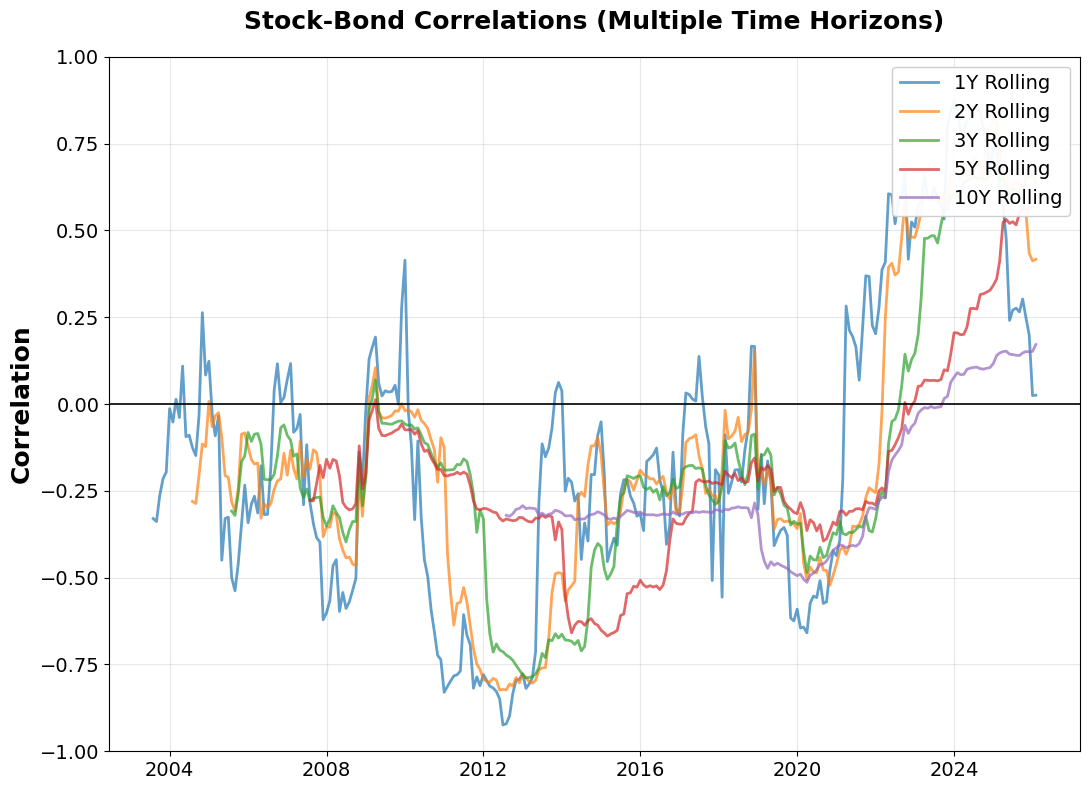

Figure saved to ../figures/stock_bond_correlation_multi.png


In [69]:
# Calculate correlations for different window sizes
windows = [12, 24, 36, 60, 120]  # 1Y, 2Y, 3Y, 5Y, 10Y
correlations = {}

for window in windows:
    corr = returns_df['SP500'].rolling(window=window).corr(returns_df['Bonds_Long'])
    correlations[f'{window//12}Y'] = corr

df_correlations = pd.DataFrame(correlations)

# Plot all correlations
fig, ax = plt.subplots(figsize=(11, 8))

for col in df_correlations.columns:
    ax.plot(df_correlations.index, df_correlations[col], 
            linewidth=2, label=f'{col} Rolling', alpha=0.7)

ax.axhline(y=0, color='black', linewidth=1.2, linestyle='-')
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Correlation', fontsize=18, fontweight='bold')
ax.set_title('Stock-Bond Correlations (Multiple Time Horizons)', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_ylim(-1.0, 1.0)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)
ax.legend(loc='upper right', fontsize=14, framealpha=0.95)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig('../figures/stock_bond_correlation_multi.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/stock_bond_correlation_multi.png")